# Grandes étapes de l'algorithme (version Fortran77)


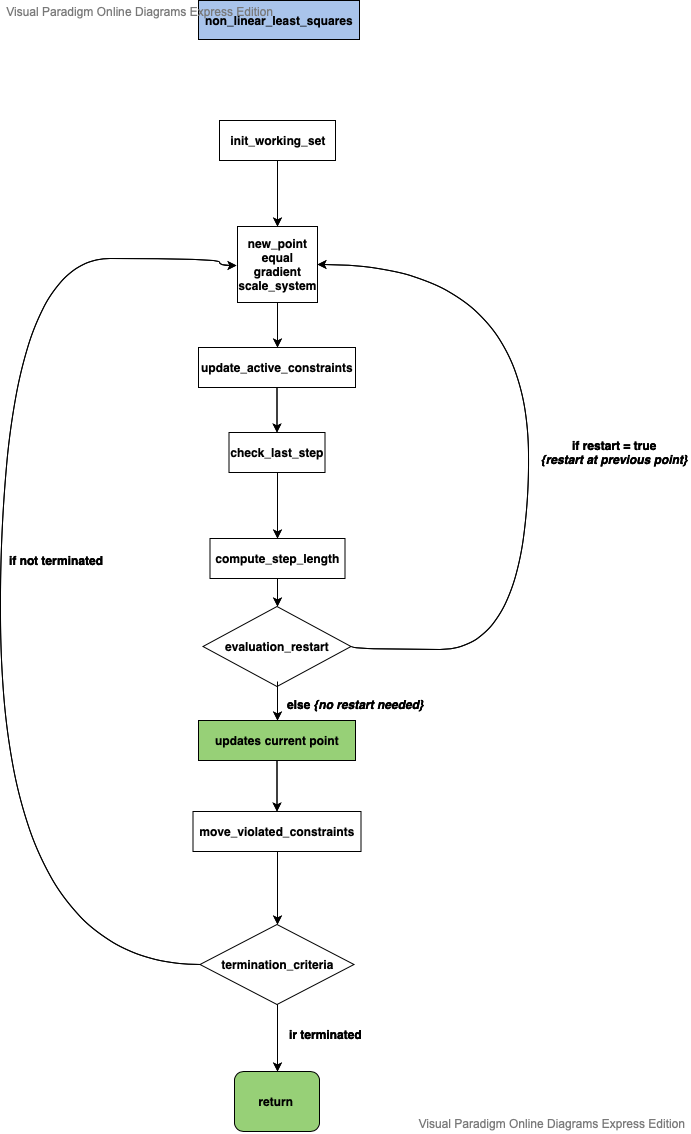


 

# Squelette du main 


In [1]:
# Fonctions appelées dans nlcls_skeleton

function init_work_space(model::Function , x::AbstractArray{Float64}, constraints::Function)
end

function check_termination_criteria(f::Function, x::AbstractArray{Float64})
    return true
end

function new_point(x::AbstractArray{Float64}, f::Function, h::Function)
end

function update_acitve_constraints(model::Function, constraints::Function, x::AbstractArray{Float64},
    latest_step::String)
end

function check_last_step(dx::AbstractArray{Float64}, f::Function, h::Function, lastest_step::String)
end

function compute_steplength(f::Function, x::AbstractArray{Float64}, dx::AbstractArray{Float64}
        , h::Function, psi::Function)
end

function evaluation_restart(f::Function, dx, alpha::Float64, h::Function, latest_step::String)
end

function move_violated_constraints(f::Function, x::AbstractArray{Float64}, h::Function)
end

move_violated_constraints (generic function with 1 method)

In [2]:
# Ne comporte pas (encore) de gestion d'erreurs
# Paramètres à détailler au fur et à lesure de l'avancement

function nlcls_skeleton(model::Function, initial_point::AbstractArray{Float64}, merit_function::Function, 
        constraints::Function)
    # Tests sur les paramètres de départ à rajouter
    
    # Initialisation des paramètres et de l'espace de travail
    
    x, dx, iter = initial_point, zeros(size(initial_point)), 0
    init_workspace(model, x, constraints)
    terminated = check_termination_criteria(model, x)
    while !terminated
        # Mise à jour de l'espace de travail avec le nouveau point
        new_point(x, model, constraints)
        latest_step = "GN"
        
        # Mise à jour des contraintes actives et calcul de la direction Gauss-Newton
        dx = update_active_constraints(model, constraints, x, latest_step)
        
        # Vérification de la dernière étape et recalcul de la direction avec méthode TQR ou Newton si besoin est
        check_last_step(dx, model, constraints, lastest_step)
        
        # Calcul du pas de l'itération (vaut 1 si méthode de Newton utilisée)
        alpha = (latest_step == "Newton" ? 1 : compute_steplength(model, x, dx, constraints, merit_function))
        
        # Si pas de restart : mise à jour du point et des contraintes
        if !evaluation_restart(model, dx, alpha, constraints, latest_step)
            x += alpha * dx
            k += 1
            move_violated_constraints(model, x, constraints)
            terminated = check_termination_criteria(model, x)
        end
    end
    return x, k
end

nlcls_skeleton (generic function with 1 method)

In [4]:
# Reprend la structure du code de l'article

function nlcls_article_skeleton(objective_function, constraints, initial_point, merit_function )
    # vérification qu'il n'y pas d'erreurs dans les paramètres, pb de dimension par ex.
    # à détailler
    
    # initialisation des paramètres
    latest_step, first, phase = "GN", "GN", "normal"
    
    # not sure about p = 0 as an initial value
    k, x, p = 0, initial_point, 0

    
    # initialisation du premier workspace
    init_work_space(objective_function, contraintes);
    terminated = check_termination_criteria(objective_function, x)
    while !terminated
        # updates the system to solve with the new point
        new_point(), equal(), gradient(), scale_system()
        if phase != "Newton"
            while !terminated || !accept_direction(p_k) || phase != "Newton"
                
                # determination of working set and computation of direction are in update_active_constraints
                # computation of GN or subspace minimization search direction
                p_k = update_active_constraints()
                if !terminated
                    compute_penalty_weights(merit_function, x)
                    alpha = compute_step_length(merit_function, x, p)
                    
                    if !accept_direction(p)
                        if phase != "recovery" phase = "sighting" end
                    else
                        x = x + alpha * p
                        k += 1
                        if phase! "recovery" phase = "normal" end
                    end
                    # in this case, check_last_step only analyses the last step
                    # moreover, it doesn't compute SUB nor Newton direction
                    phase = check_last_step(latest_step, phase, first, alpha)
                end
            end
        # use an undamped Newton type method
        else
            count = 0
            newton_failure = false
            while !terminated || !newton_failure
                pn, newton_failure = newton_search_direction(objective_function, x)
                if !terminated
                    x = x + p
                    k += 1
                end
            end
            if newton_failure
                phase, first = "recovery", "GN"
            end
        end
    end
    return x
    

LoadError: syntax: extra token "phase" after end of expression

# Direction Gauss-Newton

In [3]:
using LinearAlgebra
using Plots
using Polynomials

### Gauss-Newton sans contraintes

In [4]:
# solve min [0.5*||Ax - b||^2] using QR decomposition and without constraints
#        x
function gn_direction_unconstrained(A::AbstractMatrix{Float64}, b::AbstractArray{Float64})
    m,n = size(A)
    
    # QR decomposition of matrix A
    decomp_A = qr(A, Val(true))
    P, Q, R = decomp_A.P, decomp_A.Q, decomp_A.R
    d = (transpose(Q) * b)[1:n]
    
    # Index that avoids computation problems with A
    t_acc = maximum([j for j=1:n if max(abs(R[j,j]/R[1,1]), abs(R[1,1])) >= sqrt(eps(Float64))])
    
    # Computation of the GN search direction dx 
    dx = [UpperTriangular(R)[1:t_acc, 1:t_acc]\d[1:t_acc];zeros(n-t_acc)]
    return P*dx
end

gn_direction_unconstrained (generic function with 1 method)

### Moindres carrés linéaire sans contraintes classique (équations normales)

Vérification que Gauss-Newton sans contraintes donne la même solution qu'un moindre carré linéaire

In [5]:
# solve min [0.5*||Ax - b||^2] with normal equations
#        x 

function lls(A::AbstractMatrix{Float64}, b::AbstractArray{Float64})
    return (transpose(A) * A) \ (transpose(A) * b)
end


A = [1.0 2.4; 5.6 4.0; 12.0 6.0]
b = [12.0; 6.7; 3.0]
x_gn = gn_direction_unconstrained(A,b)
x_normal = lls(A, b)
x_gn

2-element Array{Float64,1}:
 -2.6764772754000417
  5.75974723439619

Fonctions préliminaires

# Calcul du pas

 <b> TODO </b> : Implémentation du pas avec la méthode de l'algorithme originel

### Calcul du pas avec la méthode d'Armijo-Goldstein

In [6]:
# Choix des valeurs de c et τ à approfondir 
# L'article conseille d'utiliser 3 comme borne supérieure du pas

function armijo_step(f::Function, grad_fx::Vector{Float64}, x::Vector{Float64}, dx::Vector{Float64},
        α_upper::Float64 = 3.0, c::Float64 = 0.25, τ::Float64 = 0.5)
    m = - c * dot(grad_fx, dx)
    α = α_upper
    fx, psix = f(x), f(x + α * dx)
    
    while fx - psix <= α * m
        α *= τ
        fx, psix = f(x), f(x + α * dx)
    end
    return α
end

armijo_step (generic function with 4 methods)

### Calcul pas avec la méthode de Lindstörm-Wedin utilisée dans le code Fortran

<b> Idée </b> : Minimiser $\phi(\alpha) = \dfrac{1}{2} ||f(x + \alpha dx)||^2$ ,où $f$ est la fonction objectif du problème et $dx$ la direction de descente de l'itération en cours, par minimisation d'une approximation polynomiale $p$ de $f$.

<b> Paramètres </b>

- $v_0, v_1, v_2$ sont les coefficients du polynôme qui interpole la fonction objectif $f$ au deux (ou trois) points notés $\alpha_{-1}, \alpha_0$ (ou $\alpha_{-1}, \alpha_0, \alpha_1$).

- $\alpha_{best}$ est la valeur de $\alpha$ qui vérifie $s(\alpha_{best}) = \underset{\alpha \in \{\alpha_{-1}, \alpha_0, \alpha_1\}}{min} s(\alpha)$.

- $\alpha_l$ et $\alpha_u$ (avec $\alpha_l < \alpha_u$) sont les bornes de l'intervalle dans lequel doit se trouver la valeur finale du pas $\alpha$.

<b> Fonctions préliminaires </b>

- <b> minrm </b> : Calcule le minimum de la fonction polynomiale $s(\alpha) = \dfrac{1}{2} ||p(\alpha)||^2$ avec $p(\alpha) = v_0 + v_1\alpha + v_2\alpha^2$, $v_k \in \mathbb{R}^m$ pour $k \in \{1, 2, 3\}$.
- <b> parameters_rm </b> : Calcule $\hat{\alpha}$ et $\hat{\beta}$ les deux minimiseurs de $s$ ($\alpha$ étant le minimiseur le plus pertinent).

- <b> bounds! </b> : Réajuste $\hat{\alpha}$ dans le cas où il ne se situe pas dans l'intervalle $[\alpha_l,\alpha_u]$ en remplaçant sa valeur par celle de la borne la plus proche.

- <b> newton_raphson </b> : Résout $s'(\alpha) = 0$ par la méthode de Newton-Raphson dans le cas où le critère de convergence de la résolution analytique $s''(\alpha_{best}) * \eta < 2*D_m*h_m$ n'est pas respecté.

- <b> one_root, two_roots </b> : Renvoient la/les racines réelles de $s'(\alpha) = 0$ si le critère ci-dessus pour la résolution analytique est respecté. Pour <b>two_roots</b>, $\alpha$ est la meilleure des deux racines pour le problème. 

<b> Paramètres </b>

- $v_0, v_1, v_2$ sont les coefficients du polynôme qui interpole la fonction objectif $f$ au deux (ou trois) points notés $\alpha_{-1}, \alpha_0$ (ou $\alpha_{-1}, \alpha_0, \alpha_1$).

- $\alpha_{best}$ est la valeur de $\alpha$ qui vérifie $s(\alpha_{best}) = \underset{\alpha \in \{\alpha_{-1}, \alpha_0, \alpha_1\}}{min} s(\alpha)$.

- $\alpha_l$ et $\alpha_u$ (avec $\alpha_l < \alpha_u$) sont les bornes de l'intervalle dans lequel doit se trouver la valeur finale du pas $\alpha$.

In [77]:
function minrm(v0::Vector, v1::Vector, v2::Vector, α_best::Float64, α_l::Float64, α_u::Float64)
    
    s = Polynomial([0.5*norm(v0)^2, dot(v0,v1), dot(v0,v2) + 0.5*norm(v1)^2, dot(v1,v2), 0.5*norm(v2)^2])
    ds = derivative(s)
    dds = derivative(ds)
    α_hat, β_hat = parameters_rm(v0, v1, v2, α_best, ds, dds)
    sα, sβ = s(α_hat), s(β_hat)
    α_old = α_hat
    bounds!(α_l, α_u, α_hat, sα, s)
    if α_old == β_hat
        β_hat, sβ = α_hat, s(α_hat)
    else
        bounds!(α_l, α_u, β_hat, sβ, s)
    end
    return α_hat, sα, β_hat, sβ
end


function parameters_rm(v0::Vector, v1::Vector, v2::Vector, α_best::Float64,
        ds::Polynomial{Float64}, dds::Polynomial{Float64})
    dds_best = dds(α_best)
    η, d = 0.1, 1.
    h0 = abs(ds(α_best) / dds_best )
    Dm = abs(6*dot(v1,v2) + 12*α_best*norm(v2)^2) + 24*h0*norm(v2)^2
    hm = max(h0, 1)
    
    # s'(α) = 0 is solved analytically
    if dds_best * η < 2 * Dm * hm
        
        # If t = α+a1 solves t^3 + b*t + c = O then α solves s'(α) = 0
        (a1, a2, a3) = coeffs(ds) / (2 * norm(v2)^2)
        b = a2 - a1^2/3
        c = a3 - a1 * a2/3 + 2*(a1/3)^3
        d = (c/2)^2 + (b/3)^3
        
        # Two interisting roots
        if d < 0
            α_hat, β_hat = two_roots(b, c, d, a1, α_best)
        
        # Only one root is computed     
        else
            α_hat = one_root(c, d, a1)
        end
    
    # s'(α) = 0 is solved using Newton-Raphson's method
    else
        α_hat = newton_raphson(α_best, Dm)
    end
    
    # If only one root computed
    if d >= 0 
        β_hat = α_hat 
    end

    return α_hat, β_hat
end

function bounds!(α_l::Float64, α_u::Float64, α::Float64, sα::Float64, s::Polynomial{Float64})
    α = min(α, α_u)
    α = max(α, α_l)
    sα = s(α)
end

function newton_raphson(α_best::Float64, Dm::Float64, ds::Polynomial{Float64}, dds::Polynomial{Float64})
    α, newtonstep = α_best, 0
    ε, error = 1e-4, 1.
    while error > ε || newtonstep < 3
        c = dds(α)
        h = -ds(α) / c
        α += h
        error = (2 * Dm * h^2) / abs(c)
        newtonstep += 1
    end
    return α
end

function one_root(c::Float64, d::Float64, a::Float64)
    arg1, arg2 = -c/2 + sqrt(d), -c/2 - sqrt(d)
    return arg1^(1/3) + sqrt(arg2) - a
end

function two_roots(b::Float64, c::Float64, d::Float64, a::Float64, α_best::Float64)
    φ = acos(abs(c/2) / (-b/3)^(3/2))
    t = (c <= 0 ? 2*sqrt(-b/3) : -2*sqrt(-b/3))
    
    # β1 is the global minimizerof s(α. 
    # If d is close to zero the root β1 is stable while β2 and β3 become unstable
    β1 = t * cos(φ/3) - a
    β2 = t * cos((φ + 2 * π) / 3) - a
    β3 = t * cos((φ + 4 * π) / 3) - a
    
    # Sort β1, β2 and β3 so that β1 <= β2 <= β3
    β1, β2, β3 = sort([β1, β2, β3])
    
    #β1 or β2 are now the roots of interest
    α, β = (α_best <= β2 ? (β1, β3) : (β3, β1))
    return α, β
end
    
    
    

two_roots (generic function with 1 method)

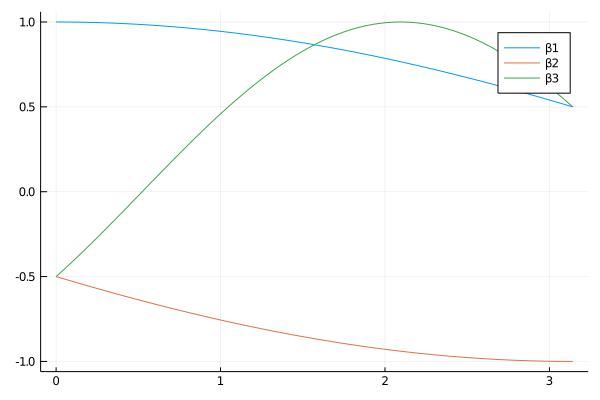

In [75]:
# Cellule de tests

x = range(0,π,length=100)
plot(x, map(x->cos(x/3), x), label="β1")
plot!(x, map(x->cos((x+2*π)/3), x), label="β2")
plot!(x, map(x->cos((x+4*π/3)), x), label="β3")
plot!()

### Calcul de direction de descente par la méthode de Newton

In [1]:
# Calcule la direction de Newton

function newton_unconstrained(grad_fx::Vector, H::Matrix)
    return H \ grad_fx
end

newton_unconstrained (generic function with 1 method)

# Résolution d'un problème de moindres carrés non linéaire sans contraintes

Paramètres :
- $(t, y)$ : données de départ à partir desquelles on ajuste le modèle
- $ initial\_point$ : point de départ de la boucle principale
- $r$ : fonction vectorielle des résidus comportant les différences entre les sorties observées et les prédictions du modèle
- $jacobian\_r$ : matrice jacobienne de la fonction $r$

In [29]:
function nlucls(t::AbstractArray{Float64}, y::AbstractArray{Float64}, r::Function, 
        initial_point::AbstractArray{Float64}, jacobian_r::Function, with_armijo::Bool = true)
    
    x = initial_point
    jac_x = jacobian_r(x)
    dx = zeros(length(x))
    f = x -> norm(r(x))
    
    grad_fx = transpose(jac_x) * jac_x * dx + transpose(jac_x) * r(x)
    iter = 0
    while norm(grad_fx) > 1e-4 && iter < 50
        # Computation of the GN-search direction 
        dx = gn_direction_unconstrained(jacobian_r(x), -r(x))
        
        # Computation of the steplength using armijo's method
        α = (with_armijo ? armijo_step(f, grad_fx, x, dx) : 1)
        
        # Update current point
        x += α * dx
        
        # Update of jacobian and gradient
        jac_x = jacobian_r(x)
        grad_fx = transpose(jac_x)*jac_x*dx + transpose(jac_x)*r(x)
        iter += 1
    end
    println("$iter itérations")
    
    return x
end

methods(nlucls)

# 2 methods for generic function "nlucls":
[1] nlucls(t::AbstractArray{Float64,N} where N, y::AbstractArray{Float64,N} where N, r::Function, initial_point::AbstractArray{Float64,N} where N, jacobian_r::Function) in Main at In[29]:4
[2] nlucls(t::AbstractArray{Float64,N} where N, y::AbstractArray{Float64,N} where N, r::Function, initial_point::AbstractArray{Float64,N} where N, jacobian_r::Function, with_armijo::Bool) in Main at In[29]:4

5 itérations
[0.36180308278463413, 0.5560725342206536]


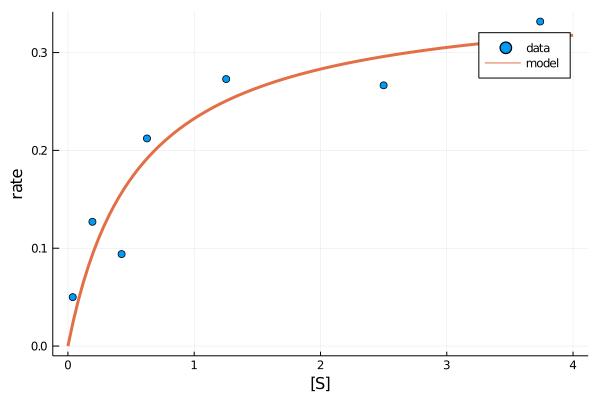

In [30]:
# Exemple pré-défini trouvé sur la page wikipédia de l'algorithme de Gauss-Newton

S = [0.038;0.194;0.425;0.626;1.253;2.500;3.740]
rate = [0.050;0.127;0.094;0.2122;0.2729;0.2665;0.3317]
function model(x::AbstractArray{Float64}, t::Float64)
    return (x[1] * t) / (x[2] + t)
end
function r(x::AbstractArray{Float64})
    return [rate[i] - model(x, S[i]) for i=1:7]
end
function jacobian_r(x::AbstractArray{Float64})
    jac1 = [-S[i] / (x[2] + S[i]) for i=1:7]
    jac2 = [(x[1]*S[i]) / (x[2]+S[i])^2 for i=1:7]
    return hcat(jac1, jac2)
end

x = nlucls(S, rate, r, [0.9;0.2], jacobian_r, false)
println(x)
t = range(0,4,length=100)
scatter(S,rate, label = "data")
plot!(t, [model(x, t[i]) for i=1:length(t)], lw=3, label = "model")
plot!(xlabel = "[S]", ylabel = "rate")



